In [1]:
# Import necessary libraries for this project
import pandas as pd
import numpy as np
import requests as rq
import json, math, time, os
import datetime as dt
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
# Create a class that calls the API
class api_caller:
    
    # Root url for Companies House database
    root_url = 'https://api.companieshouse.gov.uk/'
    
    # API key
    key = '151b89aa-44c2-4cf6-8002-53b2b46b0e7a'
    
    # Create a function that returns the dataframe of the companies found for the selected url
    def return_dataframe(self,url_extention):
        
        # Create a url variable that combines the selected url to root url
        url = self.root_url + url_extention
        
        # Request a response from the url with the API key
        query_result = rq.get(url, auth=(self.key,''))
        
        # Check if the response of the request is successfull (which is denoted with code 200)
        if query_result.status_code == 200:
            
            # Create a json file by decoding the response
            json_file = json.JSONDecoder().decode(query_result.text)
            
            # Create a variable that stores only items from the json file
            items_file = json_file['items']
            
            # Create a variable that stores the keys from the items file
            keys = items_file[0].keys()

            # Create the dataframe with companies as data and keys as columns
            companies_df = pd.DataFrame(items_file,columns = keys)
            
            # Return the created dataframe
            return companies_df
        
        else: # if the response code is not 200, return none (non-200 code, either 400 or 405, means either the request is not
              # correctly asked or there is not such a url. This is helpful on tackling the error when my upcoming return_companies
              # function goes into further pages to quest companies where there is no longer any companies listed)
            return None

In [5]:
# Get the datasets foldewr
cwd = os.getcwd() # current directory
p_cwd = os.path.abspath(os.path.join(cwd, os.pardir)) # parent of the current directory

# Create a link to SIC Codes list file uploaded to GitHub
url_sic_codes = os.path.join(p_cwd, "datasets/sic_codes_list.csv")
# Create a dataframe storing SIC Codes of companies
sic_codes_df = pd.read_csv(url_sic_codes)

In [6]:
# Create a function that returns the companies based on one single SIC code 
# and the number of expected companies
def return_companies_on_sic_code(sic_code, number_of_companies):
    
    # Round up number of pages
    number_of_pages = math.ceil(number_of_companies / 20)
    
    # Create an empty dataframe as a general dataframe to store further companies
    companies_data = pd.DataFrame()
    
    # Iterate through the pages
    for page_index in range(0, number_of_pages):
        
        # Create the url extention that checks for sic_code based on 20 companies per page and page starting 
        # index of the last companies in the previous page
        url = f"advanced-search/companies?sic_codes={sic_code}&items_per_page=20&start_index={page_index*20}"
        
        # Store the companies collected in one particular page
        page_data = api_caller().return_dataframe(url)
        
        # Add the one-page collected companies dataframe to the general dataframe
        companies_data = pd.concat((companies_data,page_data),axis=0)
        
        # Sleeps for 0.4 seconds not to crash into time errors
        time.sleep(0.4)
    
    # Return the general dataframe
    return companies_data.reset_index(drop=True)


###########################################################################################################################


# Create a function that returns the companies based on multiple single SIC codes 
# and the number of expected companies
def return_companies_on_multiple_sic_codes(sic_codes_list, number_of_companies):
    
    # Create an empty dataframe as a general dataframe to store further companies
    companies_data = pd.DataFrame()
    
    # Iterate through the input sic codes
    for sic_code in sic_codes_list:
        
        # Use the previously created one-sic-code-based companies returning function to return multiple-pages companies
        # each sic code
        companies_data_for_sic_code = return_companies_on_sic_code(sic_code, number_of_companies)
        
        # Add the companies for one sic code to general dataframe
        companies_data = pd.concat((companies_data,companies_data_for_sic_code),axis=0)
        
        # Sleeps for 0.4 seconds not to crash into time errors
        time.sleep(0.4)
    
    # Return the general dataframe
    return companies_data.reset_index(drop=True)

In [7]:
# Create a function that returns the list of SIC Codes based on the selected keywords for industry names 
def words_dependent_sic_codes(search_words_list):
    
    # Create an empty list to store further SIC Codes
    sic_codes = []
    
    # Iterate throught all industry names in SIC Codes dataframe
    for industry in sic_codes_df['Description']:
        
        # Iterate through each search_word and removable_word
        for search_word in search_words_list:
            
            # Check if the search word is in industry name
            if search_word in industry.lower():

                # Create a dataframe condition to call specific industry
                condition = (sic_codes_df['Description'] == industry)

                # Store the SIC Code of that specific industry
                sic_code = sic_codes_df[condition]['SIC Code'].values

                # Convert the stores SIC Code into integer
                sic_code_int = int(sic_code)

                # Add the integer SIC Code into SIC Codes list
                sic_codes.append(sic_code_int)
                
    # Remove the duplicated SIC Codes by converting list into set and back to list            
    sic_codes = list(set(sic_codes))
    
    # Return the SIC Codes list
    return sic_codes

In [8]:
# Create a class that filteres the dataframe
class filtering():
    
    # Ask for dataframe as an initializer
    def __init__(self,dataframe):
        
        self.dataframe = dataframe
    
    # Define a class function that filters the datarame
    def filter_by(self, filtered_value, column):
        
        # Set a condition of filter
        condition  = (self.dataframe[column] == filtered_value)
        
        # Create a filtered dataframe
        filtered_df = self.dataframe[condition]
        
        # Return the filtered dataframe
        return filtered_df
    
    # Define a class function that unfilters the datarame
    def unfilter_by(self, filtered_value, column):
        
        # Set a condition of filter
        condition  = (self.dataframe[column] == filtered_value)
        
        # Get the indices of condition values
        indices = self.dataframe[condition].index
        
        # Drop thee candidate values
        unfiltered_df = self.dataframe.drop(indices, axis=0)
        
        # Return the unfiltered dataframe
        return unfiltered_df

# Business Question 1: Which cities in UK has the highest potential for technology-related activities besides London?

In [9]:
# Create a list of words to look through in industry name
tech_words = ['technology','engineering','software','hardware']

# Create a variable that stores the selected SIC Codes
tech_sic_codes = words_dependent_sic_codes(tech_words)

In [10]:
# Call the data from Companies Houses: requesting 1000 companies per SIC Code
tech_companies_df = return_companies_on_multiple_sic_codes(tech_sic_codes, 100)

In [11]:
# Drop duplicates for columns 'company_name' which is a unique identifier for the companies
tech_companies_df.drop_duplicates(subset=['company_name'], inplace=True)

In [12]:
# Create a list of columns that are not suitable for analysis
unnecessary_columns = ['kind','links']

# Drop the candidate columns
tech_companies_df.drop(columns=unnecessary_columns, inplace=True)

In [13]:
# Create a 'locality' and 'postal_code' columns out of 'registered_office_address', which is a dictionary in a dataframe
columns_to_be_splitted = ['locality','postal_code']

# Define a function that splits the given column
def cell_dict_splitter(key, column, dataframe):

    dataframe[key] = dataframe[column].str[key]

# Iterate through the candidate columnss
for key in columns_to_be_splitted:
    
    # Split the candidate columns
    cell_dict_splitter(key,'registered_office_address',tech_companies_df)
    
# Drop 'registered_office_address' column given it has already been processed
tech_companies_df.drop(columns=['registered_office_address'], inplace=True)

In [14]:
# Drop null values from 'locality' columns given that some companies do not have registered locality
tech_companies_df.dropna(subset=['locality'], inplace=True)

In [15]:
# Filter the companies which are not located in London: cities they are located are going to be called 'Non-Capital cities'
non_london_tech_companies_df = filtering(tech_companies_df).unfilter_by('London','locality')

In [16]:
# Group the companies by their locality and count the frequency
tech_company_counts = non_london_tech_companies_df.groupby('locality').count()['company_name'].sort_values(ascending=False)

In [33]:
# Create a list of cities who are in TOP10 regarding the count of tech companies
top_10_cities = tech_company_counts[:10].index

# Create a variable that stores the counts of the companies for the selected TOP10 cities
top_10_values = tech_company_counts[:10]

# Create a crosstab that groups the data by their locality and company status: active, dissolved, administration, and liqiudation 
locality_status_crosstab = pd.crosstab(non_london_tech_companies_df.locality,non_london_tech_companies_df.company_status).sort_values(by='dissolved',ascending=False)

# Define a function that returns the counts of companies for TOP10 cities by their statusa
def return_values_by_status(status):
    
    # Create a list to store further values
    values = []
    
    # Iterate through city in top 10 cities
    for city in top_10_cities:
        
        try:
            # Create a variable that stores value
            value = locality_status_crosstab[status][city]
            
            # Add value to the list
            values.append(value)

        except KeyError:
            values.append(0)
    
    # Return values
    return values

# Gather the values for active companies
active_values = np.array(return_values_by_status('active'))

# Gather the values for dissolved companies
dissolved_values = np.array(return_values_by_status('dissolved'))

# Gather the values for administration companies
administration_values = np.array(return_values_by_status('administration'))

# Gather the values for liquidation companies
liquidation_values = np.array(return_values_by_status('liquidation'))

### Business Question 1: Mini-report and visualisation:

The UK is one of the technologically leading countries in the globe, with recent tech advancements and adaptations. However, most of the operations and advancements are heavily concentrated in its capital city, London. Though this makes London full of growth opportunities for technology-driven people, it also comes up with its harsh competition. This analysis aims to analyze the technological opportunities outside of London for, especially, conservative people who desire to initiate a tech firm but do not want to be in constant tough competition. Additionally, this analysis may be helpful for people who seek technological employment in a less competitive environment.

According to the results of the analysis, Manchester, Birmingham, and Bristol are the main non-capital cities with tech firms. They, respectively, capture 19.1%, 14.0%, and 10.6% of the total distribution of tech companies for non-capital cities. They are followed by Cambridge (10.6%), Nottingham (8.9%), and Cardiff (8.0%). Leeds, Coventry, Reading, and Sheffield are the other cities that made it to TOP10 (Figure 1).

Regarding active tech companies, Birmingham leads the way with above 120 companies, passing Manchester and Cambridge, both of which have nearly 100 active tech firms. While not huge variations are experienced with the rest of the cities, Coventry is found to have the lowest number of active firms (Figure 2).

Overall, Manchester, Birmingham, Bristol, and Cambridge are the main recommended cities for people who quest a non-aggressive tech firm launch or less-competitive tech job.

WORD COUNT: 238

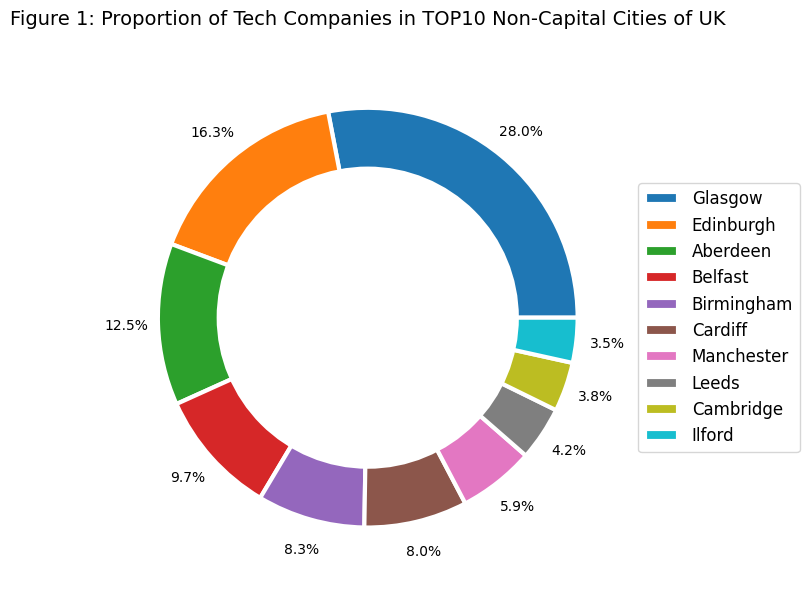

In [28]:
# Create a figure and ax plots
fig, ax = plt.subplots(figsize=(10, 6))

# Give a title to the figure
plt.title("Figure 1: Proportion of Tech Companies in TOP10 Non-Capital Cities of UK\n", fontsize=14)

# Create a pie chart for TOP10 cities given the proportion of tech companies they have
ax.pie(top_10_values, autopct='%1.1f%%', pctdistance=1.15,
       textprops={'fontsize': 10},
       wedgeprops={'linewidth': 3, 'edgecolor': 'white'})

# Create an inner circle to convert the pie chart to a donut chart
fig.gca().add_artist(plt.Circle((0, 0), 0.72, fc='white'))

# Put the legend on the side of the figure
ax.legend(loc='center left', fontsize=12, labels=top_10_cities, bbox_to_anchor=(1, 0.5))

plt.tight_layout()

# Save the figure in a folder in the current working directory
cwd = os.getcwd()
folder = os.path.join(cwd, 'figures')
os.makedirs(folder, exist_ok=True)
plt.savefig(os.path.join(folder, 'Figure 1: Proportion_of_Tech_Companies_in_TOP10_Non-Capital_Cities_of_UK.jpg'), format='jpg', bbox_inches='tight')

# Display the figure
plt.show()


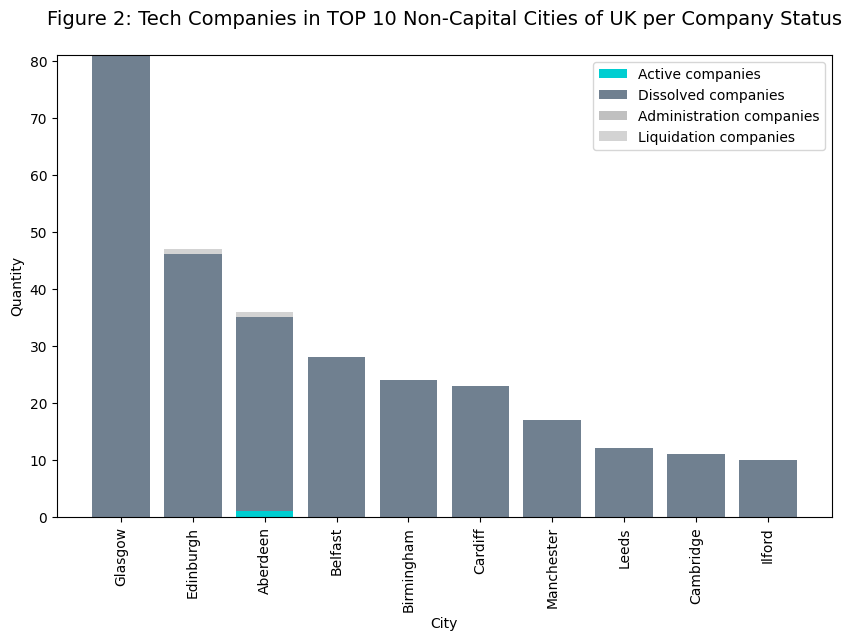

In [35]:
# Define colors for the bars
colors = ['darkturquoise',
'slategrey',
'silver',
'lightgrey']

# Create a figure and ax plots
fig, ax = plt.subplots(figsize = (10,6))

# Plot the stacked bar for active companies counts
plt.bar(top_10_cities, active_values, color=colors[0])

# Plot the stacked bar for dissolved companies counts
plt.bar(top_10_cities, dissolved_values, bottom=active_values, color=colors[1])

# Plot the stacked bar for administration companies counts
plt.bar(top_10_cities, administration_values, bottom=active_values+dissolved_values, color=colors[2])

# Plot the stacked bar for liquidation companies counts
plt.bar(top_10_cities, liquidation_values, bottom=active_values+dissolved_values+administration_values, color=colors[3])

# Rotate the x labels on 90 degrees
plt.xticks(rotation=90)

# Label the x axis
plt.xlabel("City")

# Label the y axis
plt.ylabel("Quantity")

# Label the legend items
plt.legend(["Active companies", "Dissolved companies","Administration companies","Liquidation companies"])

# Title the figure
plt.title("Figure 2: Tech Companies in TOP 10 Non-Capital Cities of UK per Company Status\n", fontsize=14)

# Save the figure in a folder in the current working directory
os.makedirs(folder, exist_ok=True)
plt.savefig(os.path.join(folder,'Figure 2: Tech Companies in TOP 10 Non-Capital Cities of UK per Company Status.jpg'), format='jpg')

# Display the chart
plt.show()